### Importing libraries

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

### Loading the Dataset

In [12]:
with open("/content/drive/MyDrive/P74-Project-5/Project 5/traffic-signs-data/train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("/content/drive/MyDrive/P74-Project-5/Project 5/traffic-signs-data/valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("/content/drive/MyDrive/P74-Project-5/Project 5/traffic-signs-data/test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [13]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [14]:
print(f'Training {X_train.shape}')
print(f'Testing {X_test.shape}')
print(f'Validating {X_validation.shape}')

Training (34799, 32, 32, 3)
Testing (12630, 32, 32, 3)
Validating (4410, 32, 32, 3)


In [15]:
with open("/content/drive/MyDrive/P74-Project-5/Project 5/traffic-signs-data/class-label-names.txt") as file_in:
    lines = {}
    for line in file_in:
        class_label = line.split('-')[0].strip()
        class_name = line.split('-')[1].split('\n')[0].strip()
        lines[int(class_label)] = class_name

In [16]:
file_to_store = open("labels.pickle", "wb")
pickle.dump(lines, file_to_store)

### Image Exploration

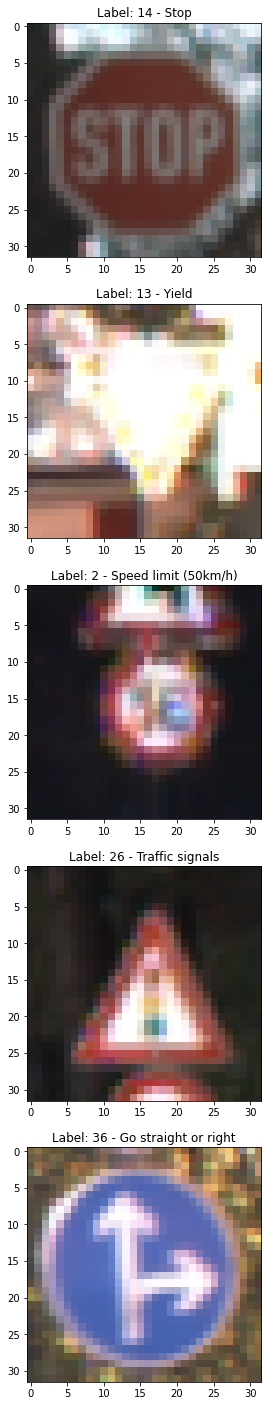

In [17]:
fig, axs = plt.subplots(5, figsize=(25, 25))

# plt.figure()

for sub in range(0, 5):
    index = random.randint(1, 34799)
    axs[sub].imshow(X_train[index])
    axs[sub].set_title(f'Label: {y_train[index]} - {lines[y_train[index]]}')

### Data Preparation

In [18]:
## Shuffle the dataset 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [19]:
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_test_gray  = np.sum(X_test/3, axis=3, keepdims=True)
X_validation_gray  = np.sum(X_validation/3, axis=3, keepdims=True) 

In [20]:
X_train_gray.shape

(34799, 32, 32, 1)

In [21]:
X_train_gray_norm = (X_train_gray - 128)/128 
X_test_gray_norm = (X_test_gray - 128)/128
X_validation_gray_norm = (X_validation_gray - 128)/128

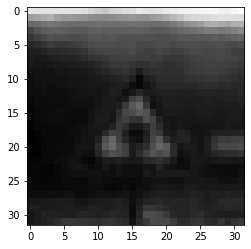

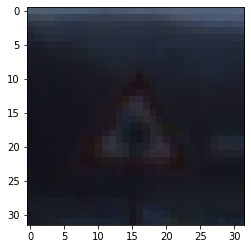

In [22]:
i = 610
plt.imshow(X_train_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i])

### Model Training

In [23]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split

In [25]:
image_shape = X_train_gray[i].shape

In [26]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
cnn_model.add(AveragePooling2D())

cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(AveragePooling2D())

cnn_model.add(Flatten())

cnn_model.add(Dense(units=120, activation='relu'))

cnn_model.add(Dense(units=84, activation='relu'))

cnn_model.add(Dense(units=43, activation = 'softmax'))


In [27]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [28]:
history = cnn_model.fit(X_train_gray_norm,
                        y_train,
                        batch_size=500,
                        epochs=50,
                        verbose=1,
                        validation_data = (X_validation_gray_norm,y_validation))

Epoch 1/50
70/70 [==============================] - 13s 13ms/step - loss: 3.1581 - accuracy: 0.1933 - val_loss: 2.6466 - val_accuracy: 0.3281
Epoch 2/50
70/70 [==============================] - 0s 7ms/step - loss: 1.6624 - accuracy: 0.5411 - val_loss: 1.4213 - val_accuracy: 0.6168
Epoch 3/50
70/70 [==============================] - 0s 6ms/step - loss: 0.9336 - accuracy: 0.7374 - val_loss: 1.0086 - val_accuracy: 0.6923
Epoch 4/50
70/70 [==============================] - 0s 6ms/step - loss: 0.6484 - accuracy: 0.8193 - val_loss: 0.8191 - val_accuracy: 0.7619
Epoch 5/50
70/70 [==============================] - 0s 6ms/step - loss: 0.5060 - accuracy: 0.8637 - val_loss: 0.7374 - val_accuracy: 0.7889
Epoch 6/50
70/70 [==============================] - 0s 6ms/step - loss: 0.4175 - accuracy: 0.8912 - val_loss: 0.6834 - val_accuracy: 0.7952
Epoch 7/50
70/70 [==============================] - 0s 7ms/step - loss: 0.3578 - accuracy: 0.9078 - val_loss: 0.6693 - val_accuracy: 0.8039
Epoch 8/50
70/70 [

In [29]:
model_json = cnn_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### Model Evaluation

In [30]:
score = cnn_model.evaluate(X_test_gray_norm, y_test,verbose=0)
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Accuracy : 0.8572


In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

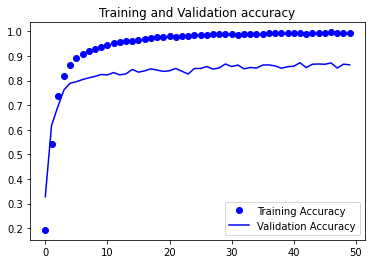

In [32]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

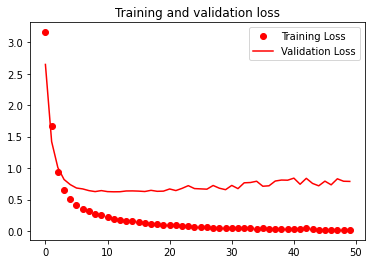

In [33]:
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [36]:
#get the predictions for the test data
predicted_classes = np.argmax(cnn_model.predict(X_test_gray_norm))
#get the indices to be plotted
y_true = y_test